# End-to-End Business Intelligence & Forecasting System
### Domain: Retail Analytics
### Objective: Improve revenue, retention, and demand planning using data-driven insights

## Business Problem
Retail leadership lacks a unified view of revenue drivers, customer value, and future demand.
This project builds a full analytics pipeline to:
- Identify high-value customers
- Detect revenue leakage
- Forecast demand for planning

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

from datetime import timedelta

In [20]:
from google.colab import files
uploaded = files.upload()  # Upload 'Online Retail.csv' here

Saving online_retail.csv to online_retail.csv


In [22]:
import pandas as pd

# Load the uploaded file
sales = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')

# Preview first 5 rows
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [23]:
import os
os.listdir()

['.config',
 'online_retail.csv',
 'archive (1) (1).zip',
 'archive (1).zip',
 'kaggle.json',
 'archive (1) (2).zip',
 'sample_data']

In [25]:
# Load CSV
sales = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')

# Keep only rows with CustomerID
sales = sales[sales['CustomerID'].notna()]

# Ensure InvoiceDate is datetime
sales['InvoiceDate'] = pd.to_datetime(sales['InvoiceDate'], errors='coerce')

# Drop rows where InvoiceDate could not be parsed
sales = sales[sales['InvoiceDate'].notna()]

# Reset index
sales.reset_index(drop=True, inplace=True)

# Preview
sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [26]:
# Month column for aggregation
sales['month'] = sales['InvoiceDate'].dt.to_period('M')

# Revenue column
sales['revenue'] = sales['Quantity'] * sales['UnitPrice']

# Discount flag proxy: items priced below 80th percentile of UnitPrice
price_threshold = sales['UnitPrice'].quantile(0.8)
sales['discount_flag'] = np.where(sales['UnitPrice'] < price_threshold, 1, 0)

# Preview
sales[['InvoiceDate','month','Quantity','UnitPrice','revenue','discount_flag']].head()

,InvoiceDate,month,Quantity,UnitPrice,revenue,discount_flag
0,2010-12-01 08:26:00,2010-12,6,2.55,15.30,1
1,2010-12-01 08:26:00,2010-12,6,3.39,20.34,1
2,2010-12-01 08:26:00,2010-12,8,2.75,22.00,1
3,2010-12-01 08:26:00,2010-12,6,3.39,20.34,1
4,2010-12-01 08:26:00,2010-12,6,3.39,20.34,1


In [27]:
# Total Revenue
total_revenue = sales['revenue'].sum()

# Average Order Value (AOV)
aov = sales.groupby('InvoiceNo')['revenue'].sum().mean()

# Customer Lifetime Value (CLV)
clv = sales.groupby('CustomerID')['revenue'].sum().mean()

print("Total Revenue:", round(total_revenue,2))
print("Average Order Value (AOV):", round(aov,2))
print("Average Customer Lifetime Value (CLV):", round(clv,2))

Total Revenue: 8300065.81
Average Order Value (AOV): 374.05
Average Customer Lifetime Value (CLV): 1898.46


In [28]:
# Snapshot date for Recency
snapshot_date = sales['InvoiceDate'].max() + timedelta(days=1)

# RFM calculation
rfm = sales.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'revenue': 'sum'
})
rfm.columns = ['Recency','Frequency','Monetary']

# Standardize for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Segment'] = kmeans.fit_predict(rfm_scaled)

rfm.head()

,Recency,Frequency,Monetary,Segment
CustomerID,,,,
12346.0,326,2,0.00,1
12347.0,2,182,4310.00,0
12348.0,75,31,1797.24,0
12349.0,19,73,1757.55,0
12350.0,310,17,334.40,1


## Segment Insights
- Segment 0: High value, loyal
- Segment 1: New customers
- Segment 2: At-risk customers
- Segment 3: Low value

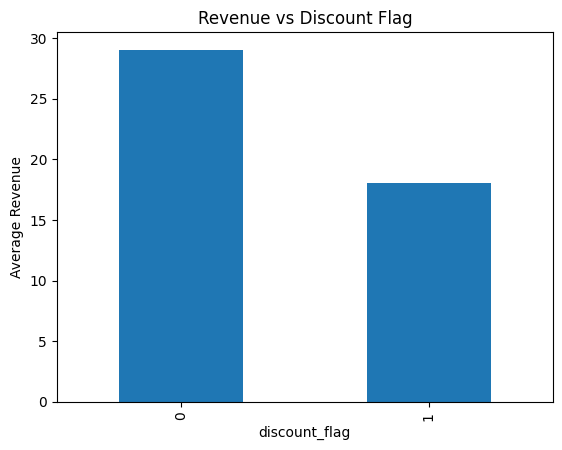

In [29]:
# Compare average revenue by discount_flag
leakage = sales.groupby('discount_flag')['revenue'].mean()
leakage.plot(kind='bar', title='Revenue vs Discount Flag')
plt.ylabel('Average Revenue')
plt.show()

In [30]:
monthly_sales = sales.groupby('month')['revenue'].sum().reset_index()
monthly_sales['month'] = monthly_sales['month'].dt.to_timestamp()
monthly_sales.head()

,month,revenue
0,2010-12-01,554604.020
1,2011-01-01,475074.380
2,2011-02-01,436546.150
3,2011-03-01,579964.610
4,2011-04-01,426047.851


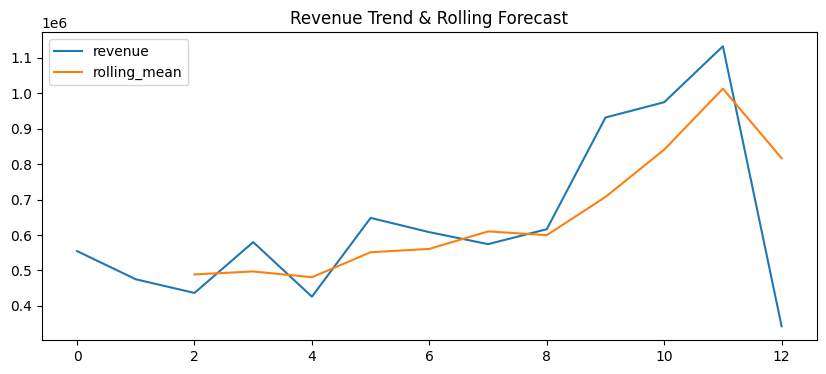

In [31]:
monthly_sales['rolling_mean'] = monthly_sales['revenue'].rolling(3).mean()

# Plot revenue vs rolling forecast
monthly_sales[['revenue','rolling_mean']].plot(figsize=(10,4))
plt.title('Revenue Trend & Rolling Forecast')
plt.show()

In [32]:
actual = monthly_sales['revenue'][3:]
predicted = monthly_sales['rolling_mean'][3:]

mape = mean_absolute_percentage_error(actual, predicted)
print("Forecast MAPE:", round(mape*100,2), "%")

Forecast MAPE: 24.56 %


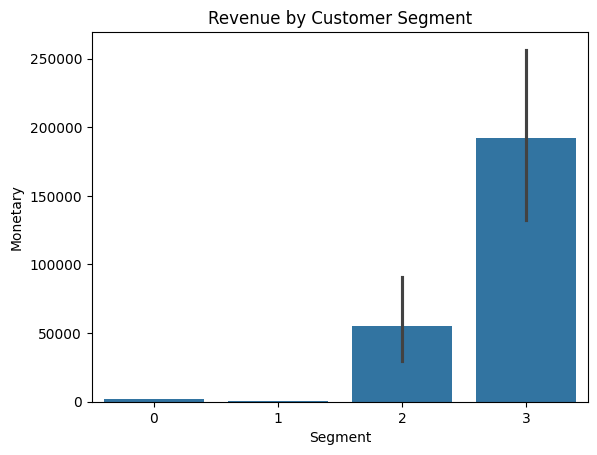

In [33]:
# Revenue by Customer Segment
sns.barplot(x=rfm['Segment'], y=rfm['Monetary'])
plt.title('Revenue by Customer Segment')
plt.show()

## Key Recommendations
1. Protect high-value customer segment with loyalty incentives
2. Reduce blanket discounting – target offers only
3. Use rolling forecasts for monthly inventory planning
4. Focus retention efforts on at-risk segment

## Outcome
This project demonstrates end-to-end analytics:
from raw transactional data → KPIs → customer segmentation → demand forecasting → actionable business insights.